# **Описание проекта**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.


Алгоритм решения:
1. Загрузим и подготовим данные.
2. Обучим разные модели.
3. Сделаем выводы.

# **Загрузка и подготовка данных.**

In [73]:
#импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
import re
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from spacy.lang.de.stop_words import STOP_WORDS
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [28]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv',  index_col=[0], parse_dates=[0])

In [29]:
data.shape

In [30]:
data.describe()

In [31]:
data.head()

In [32]:
data.info()

In [33]:
data.isnull().sum()

In [34]:
data.duplicated().sum()

In [35]:
print(data.toxic.value_counts())
ratio = data['toxic'].value_counts()[0] / data['toxic'].value_counts()[1]
print('Ratio:', ratio)

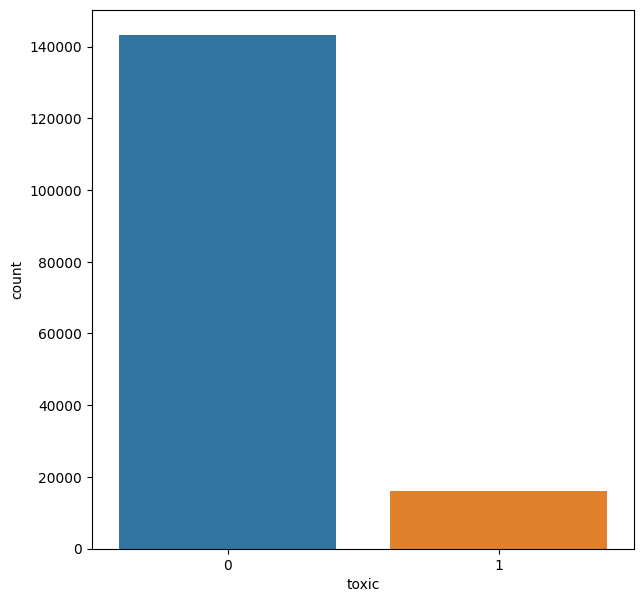

In [36]:
# Визуализируем дисбаланс классов
plt.figure(figsize=(7, 7))
sns.countplot(x='toxic', data=data);

**Минивывод**: В датасете несбалансированые классы. Нужно применить балансировку классов <br>
Размер датасета - 159292 строк и 2 столбца <br>
В данных нет пропущенных значений и дубликатов <br>
Найден дисбаланс классов в соотношении примерно 1:8 <br>

**Лемматизация текста**

In [37]:
data['text'] = data['text'].str.lower()
corpus = list(data['text'])

In [38]:
data.duplicated().sum()

При приведении комментариев к нижнему регистру были найдены дупликаты, удалим их

In [39]:
data = data.drop_duplicates().reset_index(drop= True)

In [ ]:
# лемматизируем текст
lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def clear_text(text):
    reg = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = reg.split() 
    lemm = []
    for i in range(len(clear)):
      lemm.append(lemmatizer.lemmatize(clear[i], get_wordnet_pos(clear[i])))
    return " ".join(lemm)

In [48]:
print("Исходный текст:", corpus[0])
print("Очищенный и лемматизированный текст:", lemmatize(clear_text(corpus[0])))

In [50]:
#Создалим столбец с лемматизированным текстом
data['lemmatized_text'] = data['text'].apply(clear_text)

In [51]:
data.head()

In [52]:
# создадим n-грамму n_gramm, для которой n=2
count_vect = CountVectorizer(ngram_range=(2,2))
n_gramm = count_vect.fit_transform(corpus)

print("Размер:", n_gramm.shape)

In [54]:
stop_words = set(nltk_stopwords.words('english'))
stopwords=[i.replace('"',"").strip() for i in stop_words]

In [55]:
#Создадим две таблицы: одну для токсичных комментариев, другую для нетоксичных

toxic_lem = data[data['toxic'] == 1]
nontoxic_lem = data[data['toxic'] == 0]

In [56]:
#найдем стоп-слова
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

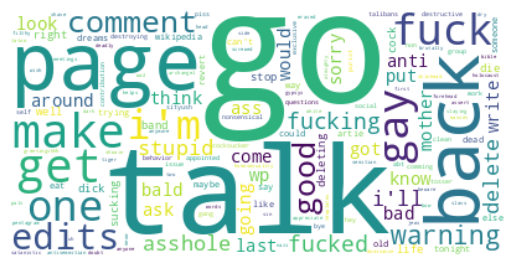

In [59]:
# найдем 100 наиболее употребимых слов для корпуса текстов токсичных комментариев
descriptions = ' '.join(data.loc[data.toxic==1,].loc[:100,"text"])
my_cloud = WordCloud(background_color='white', stopwords=stopwords).generate(descriptions)
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

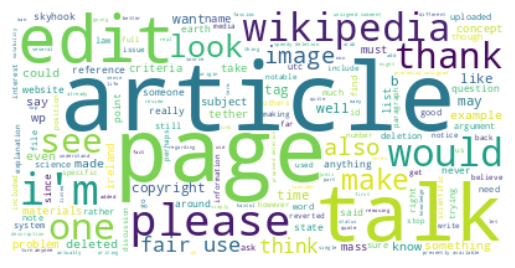

In [60]:
# найдем 100 наиболее употребимых слов для корпуса текстов нетоксичных комментариев
descriptions_nontox = ' '.join(data.loc[data.toxic==0,].loc[:100,"text"])
my_cloud = WordCloud(background_color='white', stopwords=stopwords).generate(descriptions_nontox)
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Вывод:
 - Данный датасет содержит 159292 строк и 2 столбца. В процессе предобработки данных очистили датасет и лемматизировали текст (привели слова к начальным формам) <br>
 - Обнаружили дисбаланс классов в целевом признаке <br>
 - Построили мешок слов по классам <br>


# **Обучение разных моделей**

In [61]:
target = data['toxic']
features = data.drop(['toxic', "text"], axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, test_size=0.50, random_state=12345, stratify=target_test)

In [62]:
#Определим разделение
pers_tf=features_train.shape[0]/features.shape[0]
pers_tt=target_test.shape[0]/target.shape[0]
pers_v=target_valid.shape[0]/features.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(pers_tf))
print('Размер тестовой выборки - {:.0%}'.format(pers_tt))
print('Размер валидационной выборки - {:.0%}'.format(pers_v))

In [63]:
#проверим выборки на дисбаланс классов
print(target_train.value_counts(
    normalize=True).mul(100).round(1).astype(str) + '%')
print(target_valid.value_counts(
    normalize=True).mul(100).round(1).astype(str) + '%')
print(target_test.value_counts(
    normalize=True).mul(100).round(1).astype(str) + '%')

In [64]:
# загрузим стоп-слова
stop_words = set(nltk_stopwords.words('english'))
print(stop_words)

In [65]:
# переведем слова в векторы и посчитаем TF-IDF
count_tf_idf = TfidfVectorizer(stop_words=list(STOP_WORDS))
train_tf_idf = count_tf_idf.fit_transform(features_train["lemmatized_text"])
valid_tf_idf = count_tf_idf.transform(features_valid["lemmatized_text"])
test_tf_idf = count_tf_idf.transform(features_test["lemmatized_text"])

In [66]:
vectorizer2 = TfidfVectorizer()

tfidf_matrix = vectorizer2.fit_transform(data['lemmatized_text'])

# Размер матрицы
print(tfidf_matrix.shape)

In [67]:
train_tf_idf = vectorizer2.fit_transform(features_train["lemmatized_text"])
valid_tf_idf = vectorizer2.transform(features_valid["lemmatized_text"])
test_tf_idf = vectorizer2.transform(features_test["lemmatized_text"])

In [68]:
print("Размер матрицы:", train_tf_idf.shape)
print("Размер матрицы:", valid_tf_idf.shape)
print("Размер матрицы:", test_tf_idf.shape)


Для выбора наиболее эффективной модели мы рассмотрим несколько вариантов и проанализируем их оценку качества (RMSE). Также мы учтем время, необходимое для обучения каждой модели. Три модели, которые мы обучим и проанализируем, включают LogisticRegression, Random Forest и CatBoostClassifier. После анализа мы выберем ту модель, чей результат RMSE наиболее мал и оптимальный для наших целей.

**Логистическая регрессия**

In [77]:
%%time
# найдем наилучшее значение С
for c in range(1, 10):
    model = LogisticRegression(class_weight='balanced',
                          random_state=12345,
                          max_iter=1000,
                          solver='lbfgs',
                               C=c)
    # обучим модель на тренировочной выборке
    model.fit(train_tf_idf, target_train)
    # найдем предсказания на валидационной выборке
    predicted_valid = model.predict(valid_tf_idf)
    print ("Значение С:", c)
    # напечатаем значение метрики F1
    print("F1_score:", f1_score(target_valid, predicted_valid))
    print('')
print()

Лучший гиперпараметр с = 7


## Советы по выбору модели для экономии времени   


- Деревянные модели (RF, DT) медленные, и на данном датасете не показывает хорошие результаты. Например использование случайного леса часто приводят к получению f1 = 0, потому что для этого датасета нужны деревья бОльше глубины, но это будет слишком долго считать.

Есть вариант указать в TfidfVectorizer max_features = 7000, и поперебирать n_estimators 100 и больше (плюс возможность взять большую глубину дерева)




- А вот у градиентного бустинга, который используют деревья небольшой глубины, такой проблемы нет, к тому же некоторые градиентные бустинги быстрые, это видно по их названию  (LightGBM). У LightGBM можно попробуй явно указать num_threads, но тут уж у кого как, кого-то эта модель летает, у кого-то умирает ядро.





-  Хорошие результаты показывает Логистическая регрессия. Советую сконцентрироваться у Логистической регрессии на переборе "C", а max_iter и solver которые частенько используют, лучше не трогать.



- Ещё есть такая вот интересная [моделька](https://medium.com/geekculture/passive-aggressive-algorithm-for-big-data-models-8cd535ceb2e6) (открывается с помощью VPN) [или](https://datafinder.ru/products/passivno-agressivnyy-klassifikator-v-mashinnom-obuchenii) . Можно с помощью её попробовать получить > 0.75  Она считается очень шустрой



- Не забываем n_jobs = -1 (Иногда помогает)

**Решающее дерево**

In [79]:
# обучим модель решающего дерева для классификации и подберем наилучшую глубину
%%time
for depth in range(2, 20, 2):
    #создадим модель, указав max_depth=depth
    model = DecisionTreeClassifier(random_state=12345,
                                  max_depth=depth,
                                  class_weight='balanced')
    #обучим модель
    model.fit(train_tf_idf, target_train)
    predicted_valid = model.predict(valid_tf_idf)
    DTC = f1_score(target_valid, predicted_valid)
    print('Глубина:', depth)
    print("F1_score:", DTC)
    print('')
print()

## Совет:


Можно вместо цикла использовать sklearn-ий встроенный функционал GridSearch. В случаи использования GridSearch, не нужно будет заранее делать валидационную выборку, лучшую метрику автоматом сохранят в best_score_, а лучшую модель (переобученная уже на полном наборе данных) будет хранить в best_estimator_, данные обучения положит в cv_restult_. А главное  он сделает несколько разбиений на train / validation выборки (кросс-валидация), тем самым поборется с рандомом, когда на валидации получен хороший результат только изза удачного сплита.

А еще лучше использовать связку GridSearchCV + pipeline.

[Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), это тема которая сразу затрагивает кроссвалидацию, тюнинг "векторайз", подбор гиперпараметров модели и о том что код стоит делать компактным.
    
    
- у тебя ngram_range=(1, 1), тут можно подбирать разное число n - грамм, максимизируя метрику, но как объединить перебор по ngram_range с обучением моделей, а не делать это по отдельности или с использованием цикла?! pipeline! Готовый [пример для работы с текстами](https://medium.com/@yoni.levine/how-to-grid-search-with-a-pipeline-93147835d916). Всё что нужно там есть, хотя очень лаконично. Можешь погуглить по:


    
    pipeline nlp gridsearchcv
    
    
- как избежать ошибки подглядывания в будущее, когда мы предварительно работаем с данными (шкалирование, нормализация, TfidfVectorizer итп итд)? pipeline! особенно это важно, когда мы используем кроссвалидацию. Для TfidfVectorizer делаеь .fit (обучаемся) на train, а transform на test, точно также нужно сделать для валидационной выборки. Но GS делает валидационные внутри себя, спрашивается как добраться до них и избежать подглядывания в будущее? Казалось бы никак, но нет! Pipeline! )
    
    
- pipeline позволяет делать наш код компактней и читабельней, это большой плюс, когда код будет раздуваться   



В общем если сделать GS+pieline будет вообще хорошо )  

**Случайный лес**

In [80]:
# построим модель случайного леса для регрессии с подбором наилучших гиперпараметров
# найдем наилучшую глубину дерева
%%time
for depth in range(5, 25, 5):
    model = RandomForestClassifier(random_state=12345,
                                   max_depth = depth,
                                   class_weight='balanced')
    model.fit(train_tf_idf, target_train)
    predicted_valid = model.predict(valid_tf_idf)
    RFC = f1_score(target_valid, predicted_valid)
    print('Глубина:', depth)
    print("F1_score:", RFC)
    print('')
print()

In [81]:
# найдем наилучшее количество деревьев
%%time
for est in [100, 500, 1000]:
    model = RandomForestClassifier(random_state=12345,
                                   n_estimators=est,
                                   max_depth=20,
                                   class_weight='balanced')
    model.fit(train_tf_idf, target_train)
    predicted_valid = model.predict(valid_tf_idf)
    print('Количество деревьев:', est)
    RFC = f1_score(target_valid, predicted_valid)
    print("F1_score:", RFC)
    print('')
print()

**Вывод**

In [82]:
comparison_tabl = pd.DataFrame(index=['F-score'], columns=['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier'])
comparison_tabl['LogisticRegression'] = LR
comparison_tabl['DecisionTreeClassifier'] = DTC
comparison_tabl['RandomForestClassifier'] = RFC

comparison_tabl

**Проверка модели**

In [83]:
%%time
model = LogisticRegression(class_weight='balanced',
                          random_state=12345,
                          max_iter=1000,
                          solver='lbfgs',
                           C = 7)
# обучим модель на тренировочной выборке
model.fit(train_tf_idf, target_train)
# найдем предсказания на тестовой выборке
predicted_test = model.predict(test_tf_idf)
LR = f1_score(target_test, predicted_test)
# напечатаем значение метрики F1
print("F1_score тестовой выборки:", LR)

# Совет:

Что может помочь добиться лучшего результата (от простого)?



- можно поиграться [порогом](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/). Так можно поднять метрику на процент - полтора
   
    
- подобрать лучшие гиперпараметры с использованием кроссвалидации (тут пригодится GridSearchCV)
    


    
 - полезно настраивать векторайзеры  (тут пригодится pipeline). Это конечно потребует вычислительных мощностей, ведь если даже использовать биграммы число признаков резко увеличится


     

- сгенерировать новые фичи, например  например посчитать число слов в тексте, длину слов итп итд. Или с помощью [тематического моделирования](https://pythobyte.com/python-for-nlp-topic-modeling-8fb3d689/)
    
    
    


- попробовать другие модели
    
    
    


- И совершенно другой подход, это использование предбученной модели Берта, выбрав соответствующую модель и используя полученные эмбединги, даже на небольшом тренировочном датасете можно обучить модель, которая на test покажет хорошую метрику. В этом случаи можно сразу получить метрику > 0.95 (при правильно выбранной модели)




А ещё можешь посмотреть какие слова  является наиболее важным для классификации с точки зрения модели. Получаем список слов    
    
    
    
    .get_feature_names_out().tolist()
    
    
    
Получаем коэффициенты важности (для логистическая регрессии)    
    
    .coef_.tolist()[0]



**Выводы.**

Нам был дан датасет из 159292 строк
В ходе анализа очистили датасет и лемматизировали, т.е. привели слова к начальным формам. Создали столбец с лемматизированным текстом.
Построили мешок слов по классам и нашли наиболее употребимые слова для каждого класса.
Проверили целевой признак на дисбаланс классов и обнаружили дисбаланс. При обучении моделей учитывали это.
При обучении моделей с подбором гиперпараметров наилучший результат показала модель логистической регрессии. Значение F1-меры на тестовой выборке - 0,77.


<font color='green'><b>Полезные (и просто интересные) материалы:</b> \
Для работы с текстами используют и другие подходы. Например, сейчас активно используются RNN (LSTM) и трансформеры (BERT и другие с улицы Сезам, например, ELMO). НО! Они не являются панацеей, не всегда они нужны, так как и TF-IDF или Word2Vec + модели из классического ML тоже могут справляться. \
BERT тяжелый, существует много его вариаций для разных задач, есть готовые модели, есть надстройки над библиотекой transformers. Если, обучать BERT на GPU (можно в Google Colab или Kaggle), то должно быть побыстрее.\
https://huggingface.co/transformers/model_doc/bert.html \
https://t.me/renat_alimbekov \
https://colah.github.io/posts/2015-08-Understanding-LSTMs/ - Про LSTM \
https://web.stanford.edu/~jurafsky/slp3/10.pdf - про энкодер-декодер модели, этеншены\
https://pytorch.org/tutorials/beginner/transformer_tutorial.html - официальный гайд
по трансформеру от создателей pytorch\
https://transformer.huggingface.co/ - поболтать с трансформером \
Библиотеки: allennlp, fairseq, transformers, tensorflow-text — множествореализованных
методов для трансформеров методов NLP \
Word2Vec https://radimrehurek.com/gensim/models/word2vec.html


Очень интересный (но очень-очень сложный) курс лекций: https://github.com/yandexdataschool/nlp_course .

Если нравится смотреть и слушать то есть целый курс на Ютубе https://www.youtube.com/watch?v=qDMwIQRQt-M&list=PLEwK9wdS5g0qksxWxtE5c2KuFkIfUXe3i&index=1
